# Modelando la Pandemia

**Introduccion** 

Este notebook esta separado en 3 secciones donde se analizaran diferentes metricas y variables acerca de los contagios del COVID-19 que sucedieron desde el 2020. En la primera seccion se evaluará el periodo de crecimiento exponencial de la curva de contagios, donde obtendremos el parametro "k" de cada país para luego intentar predecir este parametro a nivel mundial y contrastarlo. En la segunda seccion se busca construir un modelo clasificador que sea capaz de predecir cuando un pais esta haciendo o no cierta medida sanitaria. En la tercer seccion se hacen preguntas referentes a lo trabajado anteriormente, donde se busca obtener informacion acerca de la efectividad de la medida sanitaria, asi como tambien se busca mejorar el modelo utilizando una mayor cantidad de paises para entrenarlo.

# libs

In [30]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import warnings # supress warnings
warnings.filterwarnings('ignore')

# fx

In [31]:
def puntajes(X_test, X_train, y_test, y_test_pred, model):
  print("AC SCORE TRAIN:",accuracy_score(y_train, y_train_pred))
  print("AC SCORE TEST:",accuracy_score(y_test, y_test_pred))
  print("F1 SCORE: ", (f1_score(y_test, y_test_pred, average="weighted")))
  plot_confusion_matrix(model, X_test, y_test, values_format=".0f") 

def exponencial(t,k,t0):
  C=np.exp(k*(t-t0))
  return C

def casos_nuevos(casos):
  nuevos=np.zeros(len(casos))
  i=0
  while i<len(nuevos)-1:
    nuevos[i]=casos[i+1]-casos[i]
    i=i+1

  return nuevos

def bootstrap_simplificado(dataset, B=100):
    boots = []
    for _ in range(B):
        boots.append(np.random.choice(dataset, size=len(dataset)))
    return np.array(boots)

# EDA y Medicion de k

## EDA

In [32]:
datos=pd.read_csv(r'C:\Users\frand\Desktop\SPRINT 4\owid-covid-data.csv')
datos.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [33]:
print(datos.shape)

(166326, 67)


In [34]:
var_num = []
var_cat = []

for i in datos.columns:
  if datos.dtypes[i] != "object":
    var_num.append(i)
  else :
    var_cat.append(i)

print(f"Variables de tipo categoricas: {var_cat}")
print(f"Variables de tipo numericas: {var_num}")

Variables de tipo categoricas: ['iso_code', 'continent', 'location', 'date', 'tests_units']
Variables de tipo numericas: ['total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', 'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated

In [35]:
datos.isna().sum().sort_values(ascending=False).head(30)

weekly_icu_admissions_per_million             160893
weekly_icu_admissions                         160893
excess_mortality_cumulative_per_million       160630
excess_mortality                              160630
excess_mortality_cumulative                   160630
excess_mortality_cumulative_absolute          160630
weekly_hosp_admissions_per_million            155403
weekly_hosp_admissions                        155403
total_boosters                                148787
total_boosters_per_hundred                    148787
icu_patients_per_million                      142863
icu_patients                                  142863
hosp_patients                                 141709
hosp_patients_per_million                     141709
new_vaccinations                              128879
people_fully_vaccinated                       126085
people_fully_vaccinated_per_hundred           126085
people_vaccinated                             123339
people_vaccinated_per_hundred                 

In [36]:
# La informacion acerca de que es exactamente cada variable podemos encontrarla en el siguiente link:
# https://github.com/owid/covid-19-data/tree/master/public/data#confirmed-cases

## Seleccion de paises

El criterio a la hora de seleccionar los paises a sido basicamente el de utilizar paises de diferentes continentes, culturas, y densidades poblacionales, con la intencion de poder generalizar mejor los datos.


In [37]:
paises=datos['location'] #cargo el vector de paises
confirmados=datos['total_cases'] #carga vector todos los casos confirmados

In [38]:
sel_paises = ["Germany","France","United Kingdom","Italy","Russia","Thailand","Brazil","Argentina","United States","Mexico"]

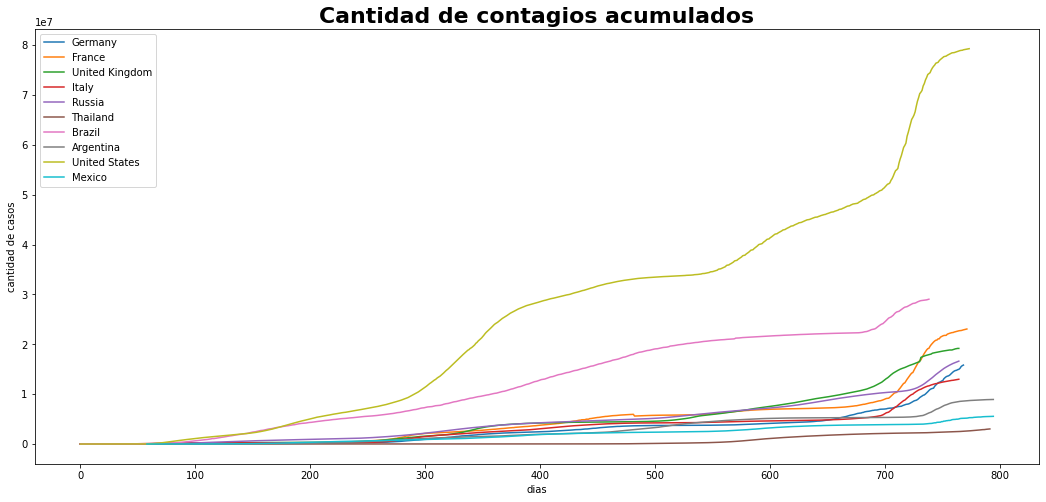

In [39]:
plt.figure(figsize=(18,8))
for i in sel_paises:

  lista = []
  ind = np.where(paises==i)
  ind = ind[0]
  casos = confirmados[ind]
  dias = np.arange(0,len(casos))
  plt.title("Cantidad de contagios acumulados", fontsize=22, fontweight ="bold")
  plt.plot(dias,casos, label=i)
  plt.xlabel('dias')
  plt.ylabel('cantidad de casos')
  plt.legend(loc=0)

In [40]:
# Luego de hacer un analisis de las ventanas de tiempo indicadas para cada pais, las incluimos en listas para una visualizacion más sencilla.

ven1 = [30,30,10,24,30,20,0,62,38,100]
ven2 = [55,90,70,50,100,80,60,122,70,160]
data_p = pd.DataFrame({"pais":sel_paises, "t0":ven1,"tf":ven2})
data_p

,pais,t0,tf
0,Germany,30,55
1,France,30,90
2,United Kingdom,10,70
3,Italy,24,50
4,Russia,30,100
5,Thailand,20,80
6,Brazil,0,60
7,Argentina,62,122
8,United States,38,70
9,Mexico,100,160


In [41]:
def info_pais (pais, t0, tf):

    ind=np.where(paises==pais)
    ind=ind[0]
    casos=confirmados[ind]
    dias=np.arange(0,len(casos))

    casos_principio=casos[t0:tf]
    dias_principio=dias[t0:tf]

    #ajustamos ---- scipy.optimize.curve_fit(f, xdata, ydata)
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)

    k=popt[0]
    t0_=popt[1]
    casos_simu=exponencial(dias_principio,k,t0_)

    dic = {"Pais": pais , "t0":[t0], "t":[tf], "k": [k]}
    datos_pais = pd.DataFrame(data=dic)
    return datos_pais

In [42]:
def graf_pais (pais, t0, tf):

    ind=np.where(paises==pais)
    ind=ind[0]
    casos=confirmados[ind]
    dias=np.arange(0,len(casos))

    casos_principio=casos[t0:tf]
    dias_principio=dias[t0:tf]

    #ajustamos ---- scipy.optimize.curve_fit(f, xdata, ydata)
    popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)

    k=popt[0]
    t0_=popt[1]
    casos_simu=exponencial(dias_principio,k,t0_)

    dic = {"Pais": pais , "t0":[t0], "t":[tf], "k": [k]}
    datos_pais = pd.DataFrame(data=dic)

    
    plt.figure(figsize=(20,5))
    plt.suptitle(pais, fontsize=22, fontweight="bold")
    

    plt.subplot(1,3,1)
    plt.plot(dias_principio,casos_principio)
    plt.title("Curva de contagio")
    plt.xlabel('dias')
    plt.ylabel('cantidad de casos')

    plt.subplot(1,3,2)
    plt.plot(dias_principio,np.log(casos_principio))
    plt.title("Logaritmo de la curva de contagio")
    plt.xlabel('dias')
    plt.ylabel('log cantidad de casos')

    plt.subplot(1,3,3)
    plt.title("Prediccion del modelo")
    plt.plot(dias_principio,casos_principio,'.')
    plt.plot(dias_principio,casos_simu)
    plt.xlabel('dias')
    plt.ylabel('cantidad de casos')
    
    plt.tight_layout()

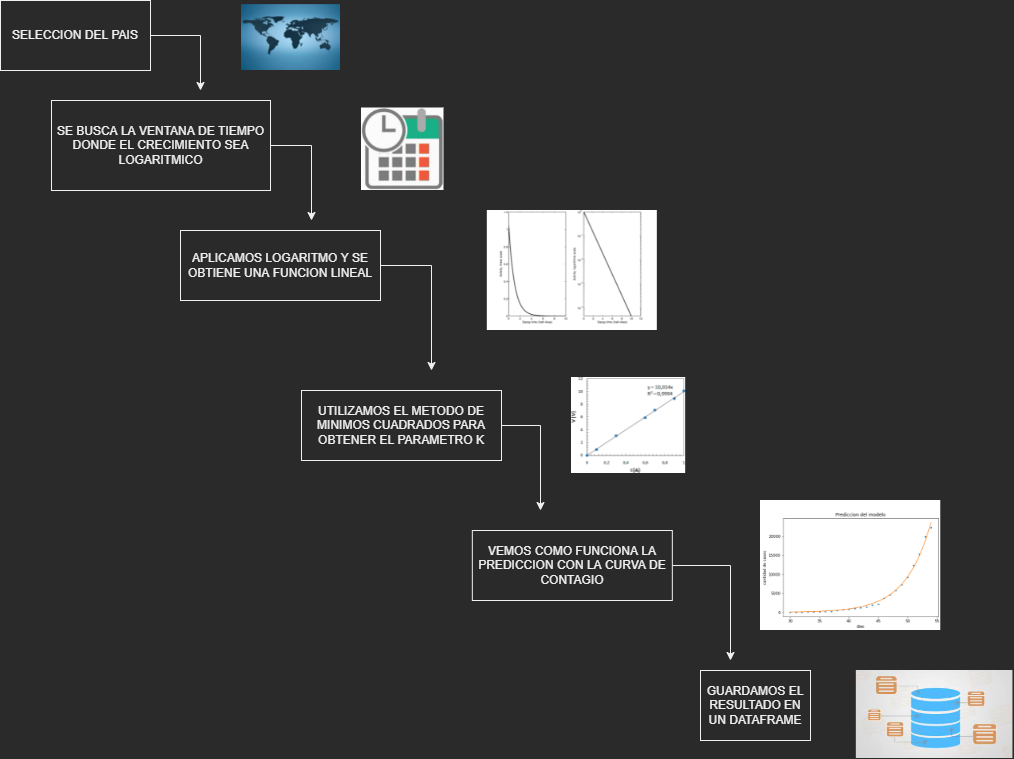

In [43]:
# Workflow propuesto

from IPython.display import Image
Image("images\wf_paises_parte1.png")

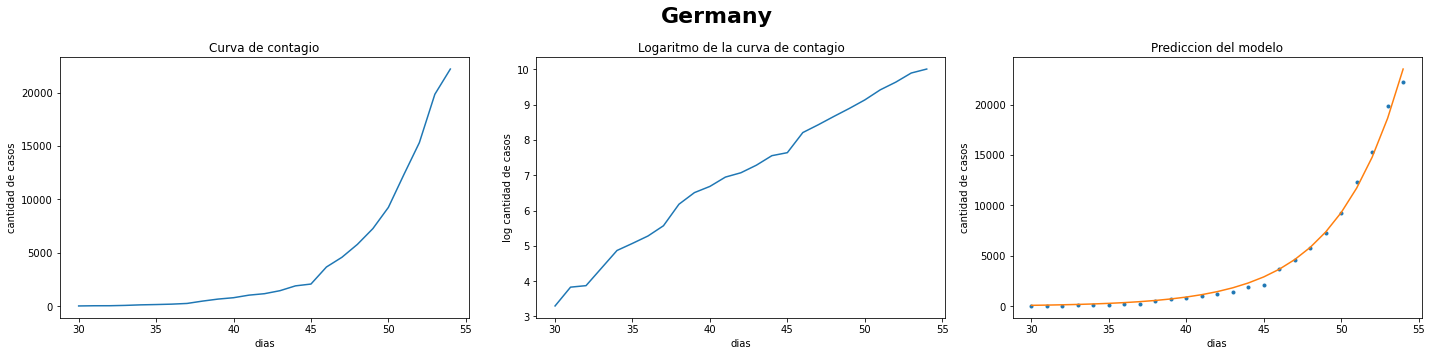

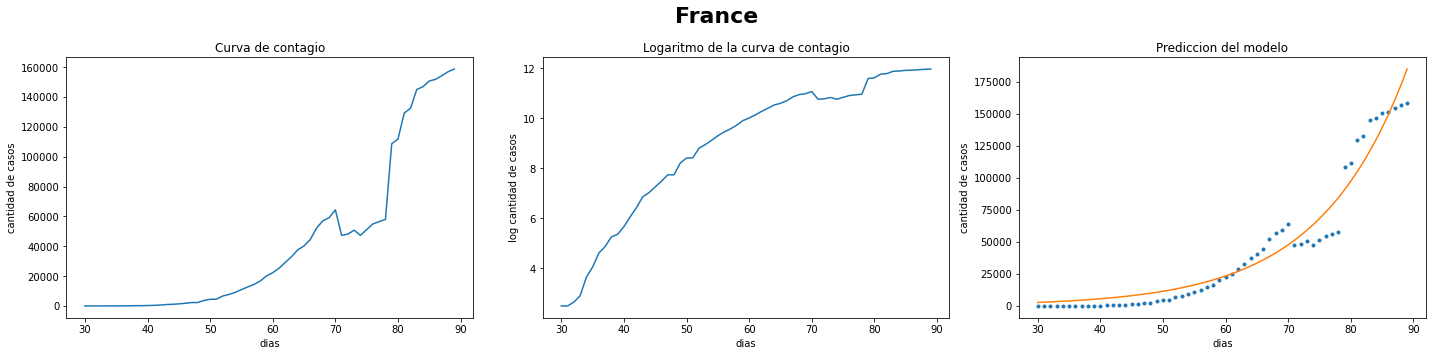

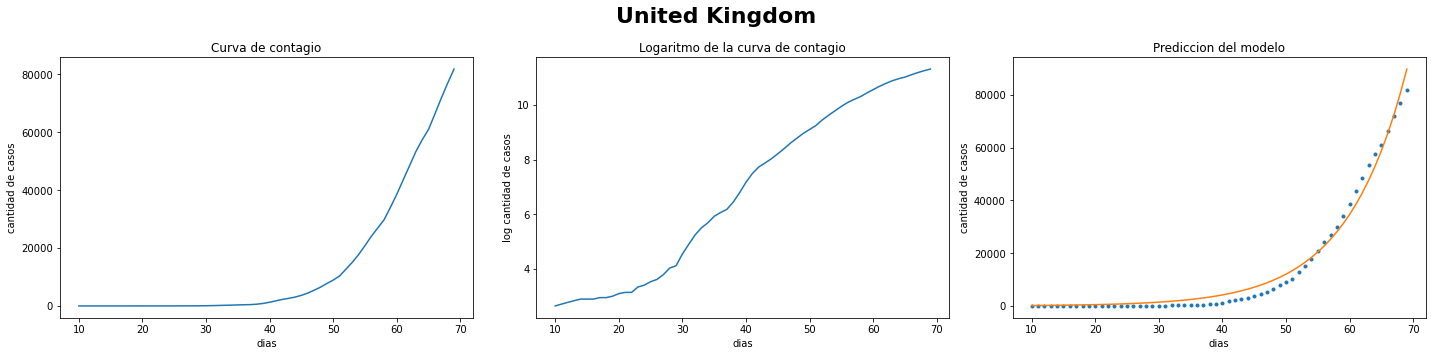

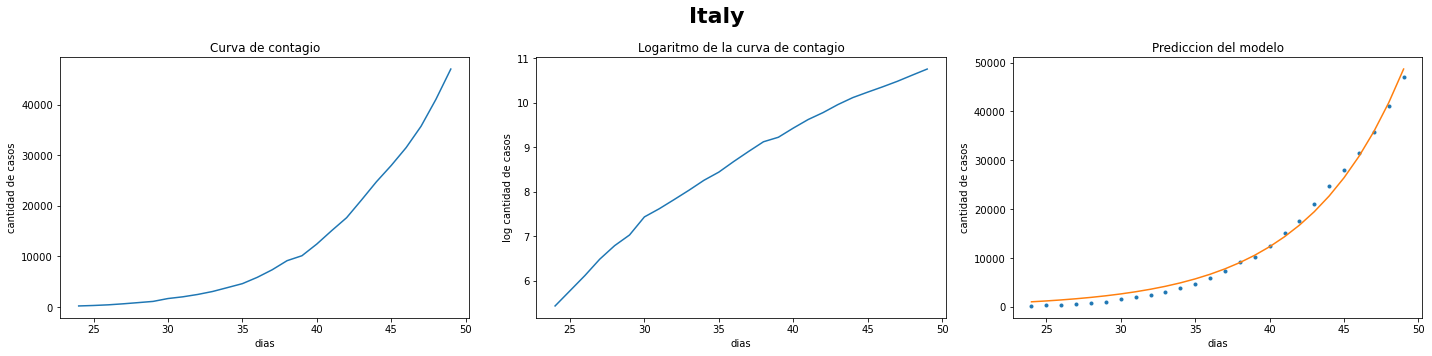

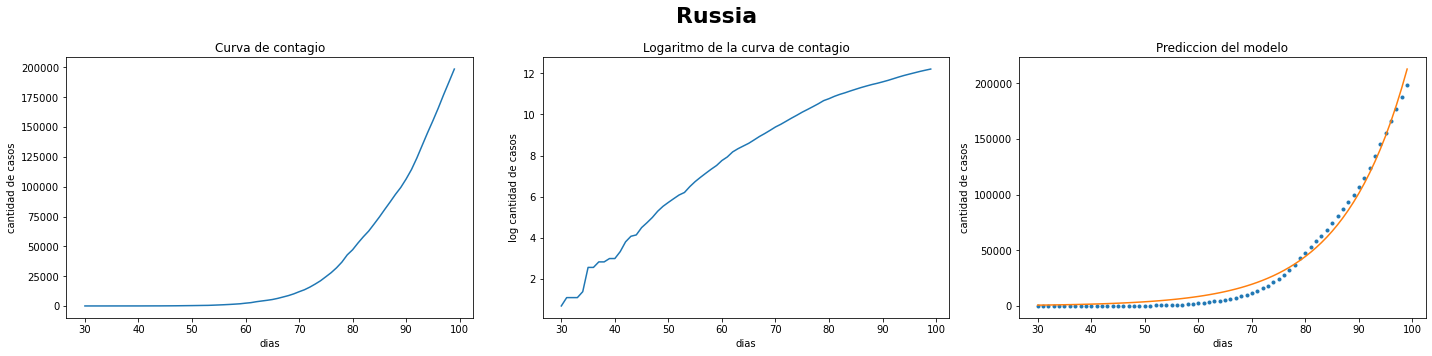

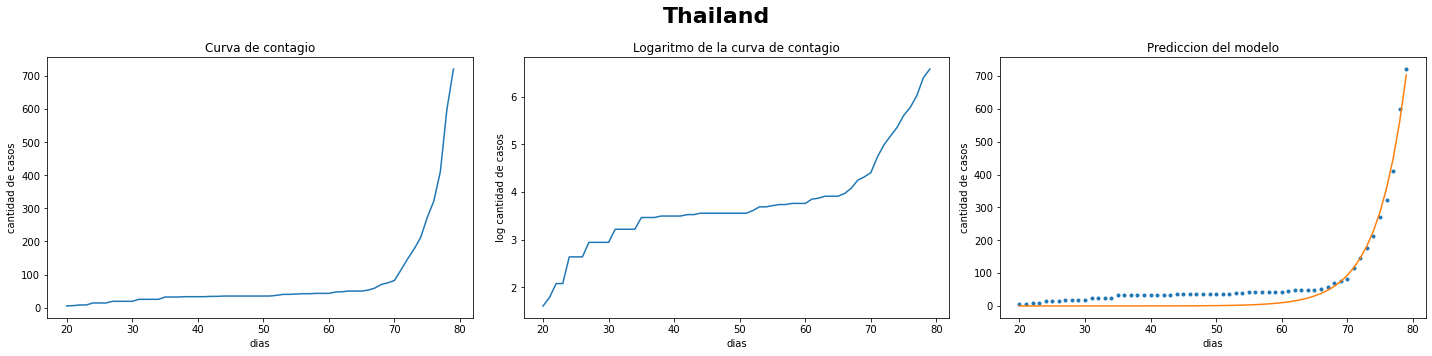

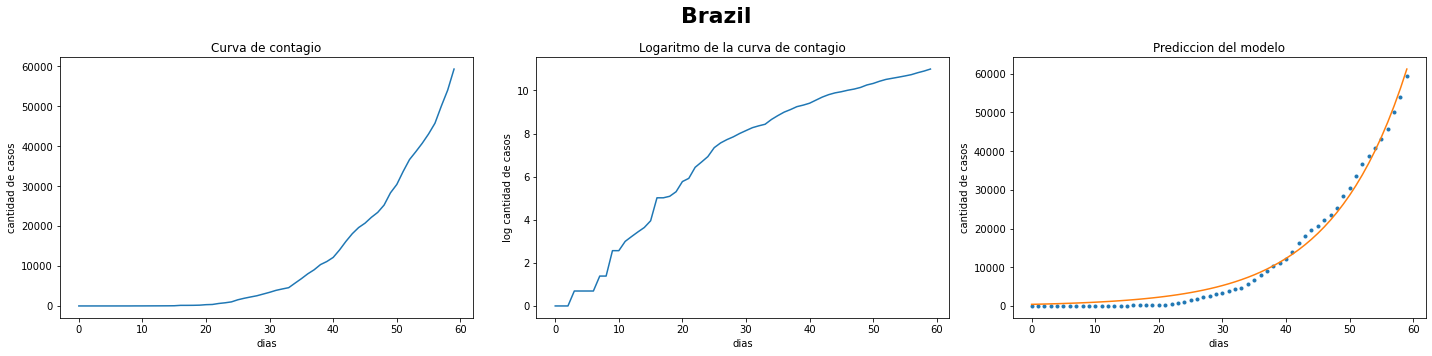

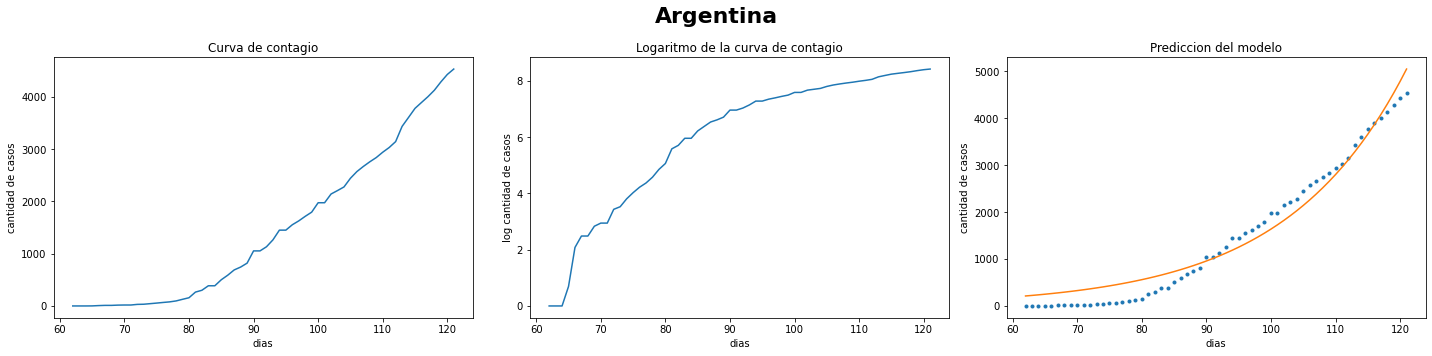

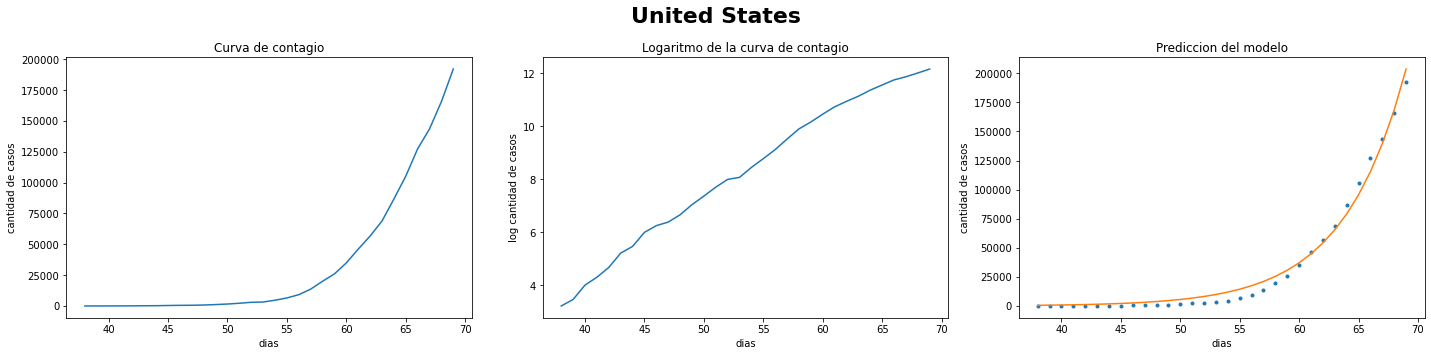

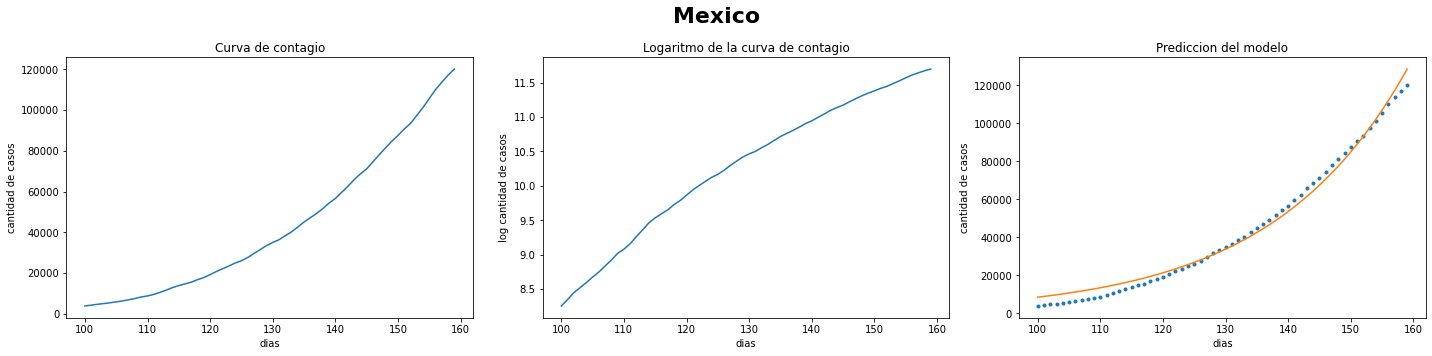

In [44]:
for i in range(len(data_p)):
    graf_pais(data_p.iloc[i].pais, data_p.iloc[i].t0, data_p.iloc[i].tf)

## Medicion de k

In [45]:
list = []

for i in range(len(data_p)):

    df = info_pais(data_p.iloc[i].pais, data_p.iloc[i].t0, data_p.iloc[i].tf)
    list.append(df)

df_f = pd.concat(list)
df_f

,Pais,t0,t,k
0,Germany,30,55,0.232304
0,France,30,90,0.071268
0,United Kingdom,10,70,0.105630
0,Italy,24,50,0.152408
0,Russia,30,100,0.082416
0,Thailand,20,80,0.224437
0,Brazil,0,60,0.084537
0,Argentina,62,122,0.053590
0,United States,38,70,0.189118
0,Mexico,100,160,0.046104


In [46]:
val_k = df_f.k
val_k

0    0.232304
0    0.071268
0    0.105630
0    0.152408
0    0.082416
0    0.224437
0    0.084537
0    0.053590
0    0.189118
0    0.046104
Name: k, dtype: float64

In [47]:
# Obtenemos valores estadisticos

print(f"Media de k: { val_k.mean() }")
print(f"Mediana de k: { val_k.median() }")
print(f"Desvio estandar de k: { val_k.std() }")

Media de k: 0.12418117084147909
Mediana de k: 0.09508349111738551
Desvio estandar de k: 0.07015389736075137


Text(0.5, 1.0, 'Distribucion de densidad de k')

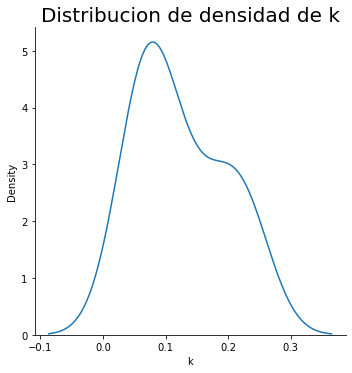

In [48]:
sns.displot(val_k, kind="kde")
plt.title("Distribucion de densidad de k", fontsize=20)

k_final=0.12292117011960982


Text(0, 0.5, 'Muestras')

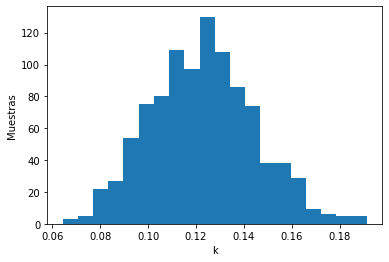

In [49]:
# Bootstrapping

datos_boots = bootstrap_simplificado(val_k,1000)
alpha = 1
medias = np.apply_along_axis(func1d=np.mean, axis=1, arr=datos_boots)
medias.sort()
k_final = medias.mean()
print(f"k_final={medias.mean()}")
plt.hist(medias, bins=20)
plt.xlabel("k")
plt.ylabel("Muestras")

In [50]:
# Construccion del intervalo de confianza
inferior = np.percentile(medias, alpha/2)
superior = np.percentile(medias, (100-alpha/2))
intervalo_confianza = [inferior, superior]
print(f"Con una certeza del 95% el valor del k promedio se encuentra en el intervalo: {intervalo_confianza}")

Con una certeza del 95% el valor del k promedio se encuentra en el intervalo: [0.07415176788905584, 0.18499182683192514]


## Mundial

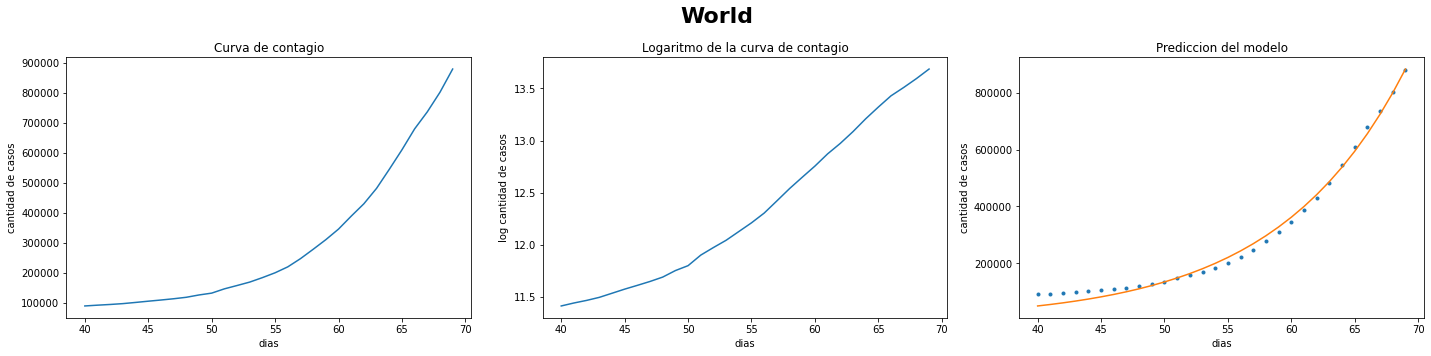

In [51]:
graf_pais("World", 40, 70)

In [52]:
info_pais("World", 40, 70)

,Pais,t0,t,k
0,World,40,70,0.099118


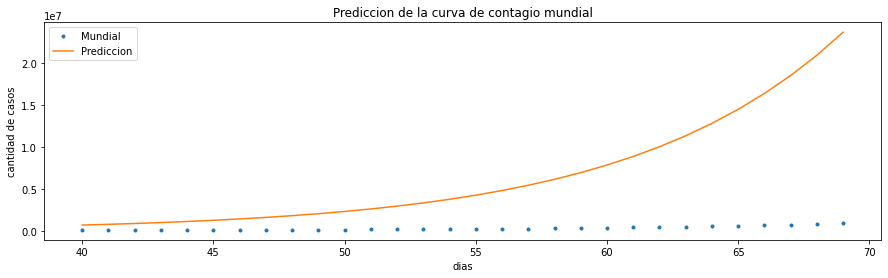

In [53]:
# Probamos el k promedio que habiamos calculado para predecir el comportamiento de la curva de contagio mundial.

ind_world=np.where(paises=='World')
ind_world=ind_world[0]
casos_world=confirmados[ind_world]
casos_principio=casos_world[40:70]
dias_principio=dias[40:70]
popt, pcov = curve_fit(exponencial, dias_principio, casos_principio)

k=popt[0]
t0=popt[1]
casos_simu=exponencial(dias_principio,k,t0)


casos_simu=exponencial(dias_principio,k_final,t0)

plt.figure(figsize=(15,4))
plt.plot(dias_principio,casos_principio,'.', label="Mundial")
plt.plot(dias_principio,casos_simu, label="Prediccion")
plt.title("Prediccion de la curva de contagio mundial")
plt.xlabel('dias') 
plt.ylabel('cantidad de casos')
plt.legend()

In [54]:
# RMSE
rmse = mean_squared_error(casos_principio, casos_simu)
print(np.format_float_scientific(rmse, precision = 1, exp_digits=3))

7.9e+013


## Conclusion

Vemos que el RMSE dio un resultado muy malo para el modelo que se propuso, pero de todas formas es lógico pensar que es improbable poder hacer un modelo con un "k" que se aproxime al "k mundial", y que sirva para predecir la cantidad de contagios. Primordialmente esto es por que si bien la infecciosidad del virus es la misma, las formas de propagarse van a variar mucho en los diferentes paises, como tambien las fechas en las que el virus comenzo a propagarse. Esto indica que para poder predecir con una precision considerable la cantidad de contagios hay que tener en cuenta la poblacion de paises bajo las mismas politicas publicas contra el virus. Estas medidas pueden ser uso de mascarilla, hacer cuarentena, vacunaciones, etc.

# Evaluando Estrategias

## Medida

La medida sanitaria elegida es la cuarentena.

In [55]:
data_cuarentena = pd.read_csv(r"C:\Users\frand\Desktop\SPRINT 4\stay-at-home-covid.csv")
data_cuarentena.Day = pd.to_datetime(data_cuarentena.Day)
data_cuarentena.stay_home_requirements.replace(1,0, inplace=True)
data_cuarentena.stay_home_requirements.replace([3,2],1, inplace=True)

In [56]:
data_cuarentena

,Entity,Code,Day,stay_home_requirements
0,Afghanistan,AFG,2020-01-01,0
1,Afghanistan,AFG,2020-01-02,0
2,Afghanistan,AFG,2020-01-03,0
3,Afghanistan,AFG,2020-01-04,0
4,Afghanistan,AFG,2020-01-05,0
...,...,...,...,...
146228,Zimbabwe,ZWE,2022-02-24,1
146229,Zimbabwe,ZWE,2022-02-25,1
146230,Zimbabwe,ZWE,2022-02-26,1
146231,Zimbabwe,ZWE,2022-02-27,1


## Seleccion de paises
https://ourworldindata.org/covid-stay-home-restrictions


Paises que SI hicieron cuarentena:

* Argentina
* Mexico
* China
* India
* Italia



Paises que NO hicieron cuarentena:
* Suecia
* Iran
* Ukraine
* Niger
* Uruguay


In [57]:
sel2_paises = ["Argentina","Mexico","China","India","Italy", "Sweden","Iran","Ukraine", "Niger", "Brazil"]

## Indicadores

**new_cases_smoothed_per_million** = Nuevos casos de COVID-19 (Media movil de 7 dias) por 1,000,000 habitantes. El contado incluye casos probables cuando son reportados.

**reproduction_rate** = Estimación en tiempo real del R (factor de reproduccion) efectivo del COVID-19

**stringency_index** = Indice de Rigurosidad de la Respuesta del Gobierno: es una medida compuesta basada en 9 indicadores que incluyen: cierres de escuelas, cierres de espacios de trabajo, prohibicion del transporte publico, etc. Esta reescalado a un valor entre 0 y 100, siendo 100 el valor de mas estricto. 

## Dataframe

In [58]:
datos_paises = datos[(datos.location.isin(sel2_paises)) & (datos.date < "2022-05-01")]
datos_paises = datos[datos.location.isin(sel2_paises)]
datos_paises = datos_paises[["location","date","new_cases_smoothed_per_million","reproduction_rate","stringency_index"]]
datos_paises.date = pd.to_datetime(datos_paises.date)
datos_paises

,location,date,new_cases_smoothed_per_million,reproduction_rate,stringency_index
5854,Argentina,2020-01-01,NaN,NaN,0.0
5855,Argentina,2020-01-02,NaN,NaN,0.0
5856,Argentina,2020-01-03,NaN,NaN,0.0
5857,Argentina,2020-01-04,NaN,NaN,0.0
5858,Argentina,2020-01-05,NaN,NaN,0.0
...,...,...,...,...,...
155685,Ukraine,2022-03-01,178.649,0.10,NaN
155686,Ukraine,2022-03-02,90.506,0.06,NaN
155687,Ukraine,2022-03-03,0.000,NaN,NaN
155688,Ukraine,2022-03-04,0.000,NaN,NaN


## Correlacion

Text(0.5, 1.0, 'Correlacion entre los indicadores')

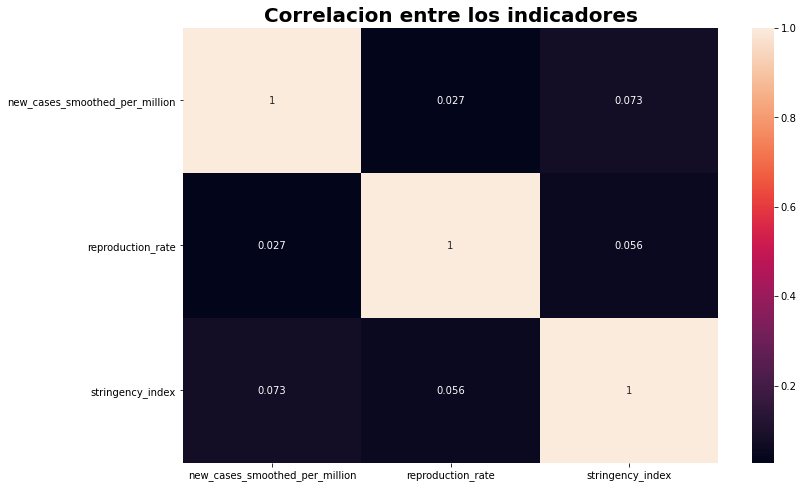

In [59]:
# Analisis de Correlacion entre los indicadores 

corr_df = datos_paises.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_df, annot=True)
plt.title("Correlacion entre los indicadores", fontsize=20, fontweight="bold")

## Ejemplo Argentina

In [60]:
cuaren_arg = data_cuarentena[(data_cuarentena.Entity == "Argentina")&(data_cuarentena.Day < "2022-05-01")&(data_cuarentena.Day >= "2020-03-03")]
cuaren_arg.set_index("Day", inplace=True)

In [61]:
cuaren_arg

,Entity,Code,stay_home_requirements
Day,,,
2020-03-03,Argentina,ARG,0
2020-03-04,Argentina,ARG,0
2020-03-05,Argentina,ARG,0
2020-03-06,Argentina,ARG,0
2020-03-07,Argentina,ARG,0
...,...,...,...
2022-02-17,Argentina,ARG,0
2022-02-18,Argentina,ARG,0
2022-02-19,Argentina,ARG,0


Text(0.5, 0, 'fecha')

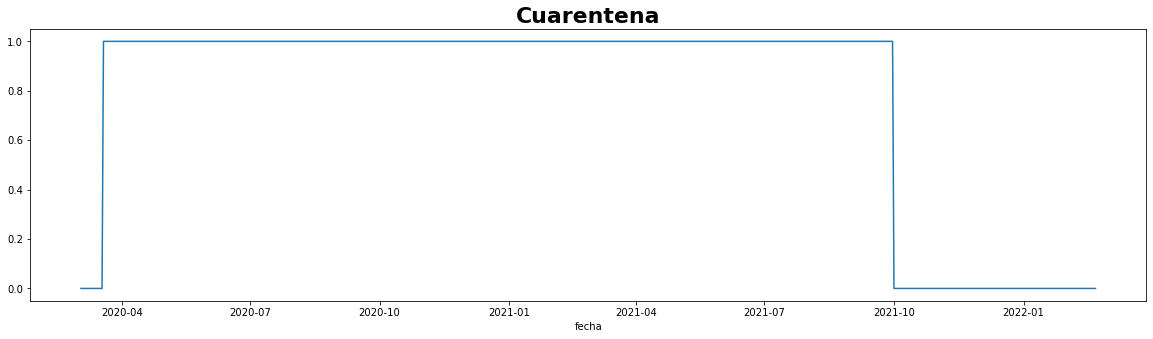

In [62]:
plt.figure(figsize=(20,5))
plt.plot(cuaren_arg.stay_home_requirements)
plt.title("Cuarentena", fontsize= 22, fontweight="bold")
plt.xlabel("fecha")

In [63]:
dt_arg = datos_paises[(datos_paises.location == "Argentina")]
dt_arg.drop(columns="location", inplace=True)
dt_arg.dropna(inplace=True)
dt_arg.set_index("date", inplace=True)
dt_arg["y_cuarentena"] = cuaren_arg.stay_home_requirements

In [64]:
dt_arg

,new_cases_smoothed_per_million,reproduction_rate,stringency_index,y_cuarentena
date,,,,
2020-03-21,0.388,2.35,88.89,1
2020-03-22,0.692,2.37,88.89,1
2020-03-23,0.767,2.23,100.00,1
2020-03-24,0.999,2.11,100.00,1
2020-03-25,0.965,2.01,100.00,1
...,...,...,...,...
2022-02-17,311.430,0.55,37.04,0
2022-02-18,307.940,0.57,37.04,0
2022-02-19,296.930,0.58,37.04,0


In [65]:
dt_arg.isna().sum()

new_cases_smoothed_per_million    0
reproduction_rate                 0
stringency_index                  0
y_cuarentena                      0
dtype: int64

### Modelo

In [66]:
X = dt_arg.drop(columns=["y_cuarentena"])
y = dt_arg.y_cuarentena

In [67]:
logreg = LogisticRegression()

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [69]:
#  penalty — Specify the norm of the penalty.
#  C — Inverse of regularization strength; smaller values specify stronger regularization.
#  solver — Algorithm to use in the optimization problem.
#  max_iter — Maximum number of iterations taken for the solvers to converge.

# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [70]:
model = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [71]:
model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [72]:
print("Tuned Hyperparameters :", model.best_params_)
print("Accuracy :",model.best_score_)

Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 1.0


In [73]:
logreg = LogisticRegression(**model.best_params_)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.001, solver='newton-cg')

In [74]:
y_test_pred = logreg.predict(X_test)
y_train_pred = logreg.predict(X_train)

AC SCORE TRAIN: 1.0
AC SCORE TEST: 1.0
F1 SCORE:  1.0


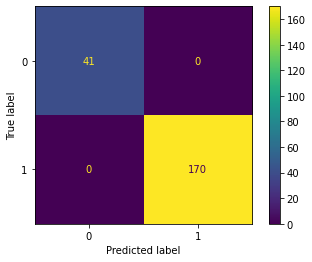

In [75]:
puntajes(X_test, X_train, y_test, y_test_pred, logreg)

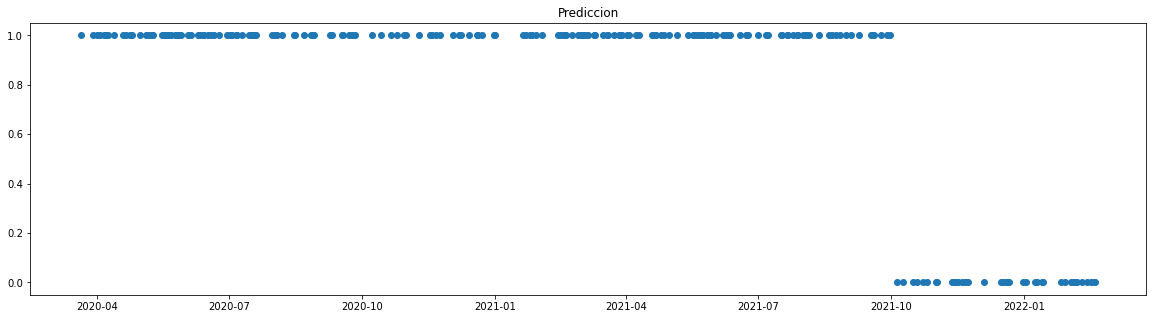

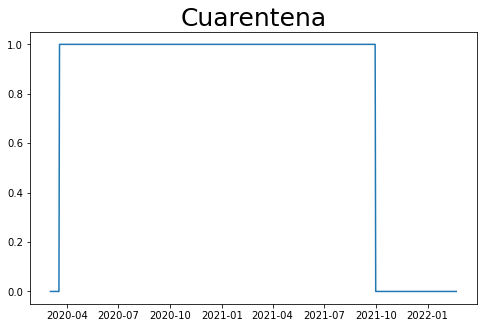

In [76]:
plt.figure(figsize=(20,5))
plt.scatter(X_test.index, y_test_pred)
plt.title("Prediccion")

plt.figure(figsize=(8,5))
plt.title("Cuarentena", fontsize=25)
plt.plot(cuaren_arg.stay_home_requirements)

In [77]:
score_arg = logreg.score(X_test, y_test)
w0 = logreg.intercept_[0]
w = w1, w2, w3 = logreg.coef_[0]
 
equation = "y = %f + (%f * x1) + (%f * x2) + (%f * x3)" % (w0, w1, w2, w3)
print(equation)

model_arg_ec = pd.DataFrame({"Pais":"Argentina","w0":[w0], "w1":[w1], "w2":[w2], "w3":[w3], "Score":[score_arg]})
model_arg_ec

y = -10.539919 + (-0.000302 * x1) + (-0.001066 * x2) + (0.187946 * x3)


,Pais,w0,w1,w2,w3,Score
0,Argentina,-10.539919,-0.000302,-0.001066,0.187946,1.0


                          feature  importance
2                stringency_index    1.206769
0  new_cases_smoothed_per_million    0.999698
1               reproduction_rate    0.998935


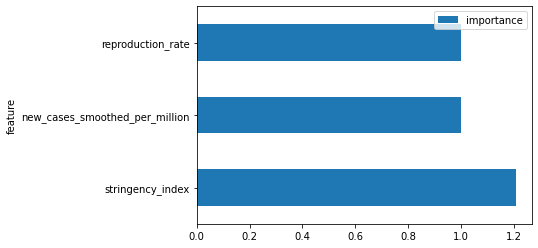

In [78]:
import math
feature_names = ["new_cases_smoothed_per_million","reproduction_rate","stringency_index"]
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
print(feature_importance)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

## 10 PAISES

### Preprocesamiento

In [79]:
cuaren_paises = data_cuarentena[data_cuarentena.Entity.isin(sel2_paises)]
cuaren_paises.set_index("Day", inplace=True)

In [80]:
list = []

for i in sel2_paises:

    dt = datos_paises[(datos_paises.location == i)]
    dt.drop(columns="location", inplace=True)
    dt.fillna(0,inplace=True)
    dt.set_index("date", inplace=True)
    dt["y_cuarentena"] = cuaren_paises[cuaren_paises.Entity == i].stay_home_requirements
    list.append(dt)

dt_modelo = pd.concat(list)

In [81]:
dt_modelo.reset_index(drop=True)

,new_cases_smoothed_per_million,reproduction_rate,stringency_index,y_cuarentena
0,0.000,0.00,0.0,0.0
1,0.000,0.00,0.0,0.0
2,0.000,0.00,0.0,0.0
3,0.000,0.00,0.0,0.0
4,0.000,0.00,0.0,0.0
...,...,...,...,...
7588,305.015,0.48,0.0,1.0
7589,235.761,0.45,0.0,1.0
7590,211.914,0.00,0.0,1.0
7591,199.192,0.00,0.0,1.0


In [82]:
dt_modelo.isna().sum()

new_cases_smoothed_per_million     0
reproduction_rate                  0
stringency_index                   0
y_cuarentena                      66
dtype: int64

In [83]:
dt_modelo.dropna(inplace=True)

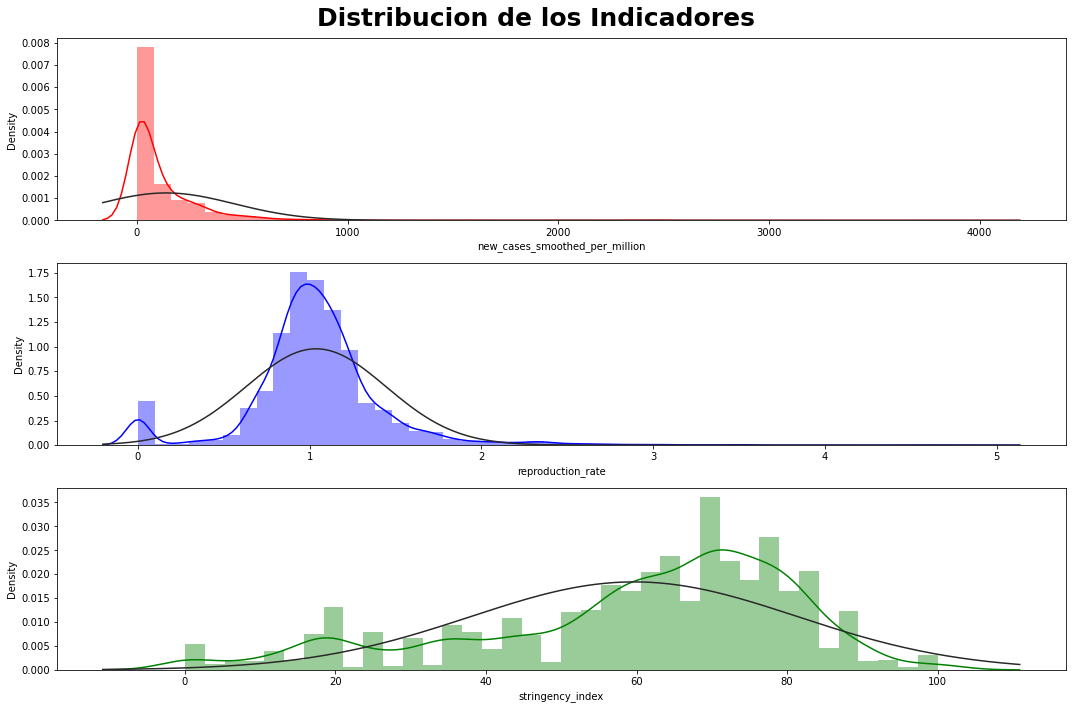

In [84]:
from scipy.stats import norm
#distribuciones
fig, axes = plt.subplots(3, figsize=(15,10))

fig.suptitle('Distribucion de los Indicadores', fontsize="25", fontweight="bold")

sns.distplot(ax=axes[0], a=dt_modelo.new_cases_smoothed_per_million,fit=norm, kde=True,color= "r")
sns.distplot(ax=axes[1], a=dt_modelo.reproduction_rate,fit=norm, kde=True, color= "b")
sns.distplot(ax=axes[2], a=dt_modelo.stringency_index,fit=norm, kde=True,  color= "g")

plt.tight_layout()


In [85]:
X = dt_modelo.drop(columns=["y_cuarentena"])
y = dt_modelo.y_cuarentena

### Modelos

#### Regresion Logistica

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

In [87]:
logreg = LogisticRegression()
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [88]:
model = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [89]:
model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [90]:
print("Tuned Hyperparameters :", model.best_params_)
print("Accuracy :",model.best_score_)

Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.8485115547506872


In [91]:
logreg = LogisticRegression(**model.best_params_)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.001, solver='newton-cg')

In [92]:
y_test_pred = logreg.predict(X_test)
y_train_pred = logreg.predict(X_train)

AC SCORE TRAIN: 0.8506074411541382
AC SCORE TEST: 0.8397521027003099
F1 SCORE:  0.8391228242328477


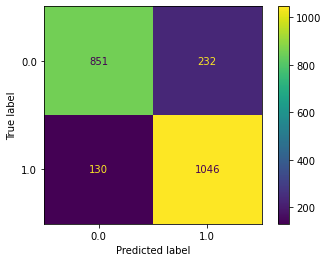

In [93]:
puntajes(X_test,X_train,y_test, y_test_pred, logreg)

In [94]:
score_paises = logreg.score(X_test, y_test)
w0 = logreg.intercept_[0]
w = w1, w2, w3 = logreg.coef_[0]
 
equation = "y = %f + (%f * x1) + (%f * x2) + (%f * x3)" % (w0, w1, w2, w3)
print(equation)

model_paises_ec = pd.DataFrame({"Seleccion":"Paises","w0":[w0], "w1":[w1], "w2":[w2], "w3":[w3], "Score":[score_paises]})
model_paises_ec

y = -7.978137 + (-0.000715 * x1) + (-0.077064 * x2) + (0.131434 * x3)


,Seleccion,w0,w1,w2,w3,Score
0,Paises,-7.978137,-0.000715,-0.077064,0.131434,0.839752


##### Importancias de los indicadores

                          feature  importance
2                stringency_index    1.140463
0  new_cases_smoothed_per_million    0.999285
1               reproduction_rate    0.925831


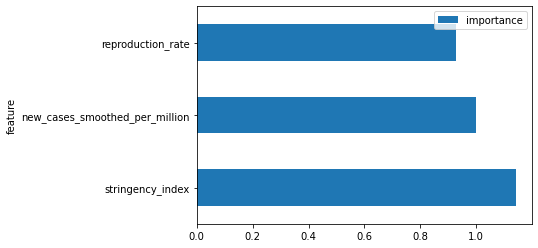

In [95]:
feature_names = ["new_cases_smoothed_per_million","reproduction_rate","stringency_index"]
feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
print(feature_importance)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

#### Naive Bayes

In [96]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [97]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
model = GridSearchCV(gnb,                    # model
                   param_grid = params_NB,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
model.fit(X_train,y_train)
print(model.best_params_)
print(model.best_score_)

{'var_smoothing': 5.3366992312063123e-05}
0.7944105742382811


AC SCORE TRAIN: 0.7955580865603644
AC SCORE TEST: 0.7910579902611775
F1 SCORE:  0.7858979609447193


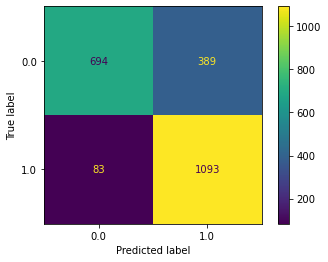

In [98]:
gnb = GaussianNB(**model.best_params_)
gnb.fit(X_train, y_train)
y_test_pred = gnb.predict(X_test)
y_train_pred = gnb.predict(X_train)
puntajes(X_test,X_train,y_test, y_test_pred, gnb)

# Prueba en paises nuevos

## Preprocesamiento

In [99]:
sel3paises = ["India","Spain","Chile","Germany","United States","Russia","France","Thailand","Kazakhstan","Australia"]

In [100]:
cuaren_paises = data_cuarentena[data_cuarentena.Entity.isin(sel3paises)]
cuaren_paises.set_index("Day", inplace=True)

In [101]:
datos_paises = datos[(datos.location.isin(sel3paises)) & (datos.date < "2022-05-01")]
datos_paises = datos[datos.location.isin(sel3paises)]
datos_paises = datos_paises[["location","date","new_cases_smoothed_per_million","reproduction_rate","stringency_index"]]
datos_paises.date = pd.to_datetime(datos_paises.date)
datos_paises

,location,date,new_cases_smoothed_per_million,reproduction_rate,stringency_index
8908,Australia,2020-01-26,NaN,NaN,5.56
8909,Australia,2020-01-27,NaN,NaN,5.56
8910,Australia,2020-01-28,NaN,NaN,5.56
8911,Australia,2020-01-29,NaN,NaN,5.56
8912,Australia,2020-01-30,NaN,NaN,5.56
...,...,...,...,...,...
157991,United States,2022-03-01,187.229,0.59,NaN
157992,United States,2022-03-02,173.693,0.59,NaN
157993,United States,2022-03-03,167.231,NaN,NaN
157994,United States,2022-03-04,158.492,NaN,NaN


In [102]:
list = []

for i in sel3paises:

    dt = datos_paises[(datos_paises.location == i)]
    dt.drop(columns="location", inplace=True)
    dt.fillna(0,inplace=True)
    dt.set_index("date", inplace=True)
    dt["y_cuarentena"] = cuaren_paises[cuaren_paises.Entity == i].stay_home_requirements
    list.append(dt)

dt_modelo_2 = pd.concat(list)

In [103]:
dt_modelo_2.isna().sum()

new_cases_smoothed_per_million     0
reproduction_rate                  0
stringency_index                   0
y_cuarentena                      61
dtype: int64

In [104]:
dt_modelo_2.dropna(inplace=True)

## Modelos

In [105]:
X_final = dt_modelo_2.drop(columns="y_cuarentena")
y_final = dt_modelo_2.y_cuarentena

### Regresion Logistica

In [106]:
y_final_predict = logreg.predict(X_final)

In [107]:
from sklearn.metrics import accuracy_score
accuracy_score(y_final, y_final_predict)

0.78629883843717

### Naive Bayes

In [108]:
y_final_predict = gnb.predict(X_final)
from sklearn.metrics import accuracy_score
accuracy_score(y_final, y_final_predict)

0.7506599788806758

## Conclusion

Podemos decir que el modelo de regresion logistica que hemos entrenado con 5 paises que hicieron cuarentena y 5 que no, debido a una precision aceptable, puede servir para predecir cuando otro pais esta haciendo o no cuarentena en base a los indicadores propuestos. 

# Investigacion

## ¿Como funciona el modelo si lo probamos con todos los paises del dataset?

### Preprocesamiento

In [109]:
cuaren_todo = data_cuarentena.copy()
cuaren_todo.set_index("Day", inplace=True)

In [110]:
todo_dt = datos[["location","date","new_cases_smoothed_per_million","reproduction_rate","stringency_index"]]
todo_dt.date = pd.to_datetime(todo_dt.date)
todo_dt

,location,date,new_cases_smoothed_per_million,reproduction_rate,stringency_index
0,Afghanistan,2020-02-24,NaN,NaN,8.33
1,Afghanistan,2020-02-25,NaN,NaN,8.33
2,Afghanistan,2020-02-26,NaN,NaN,8.33
3,Afghanistan,2020-02-27,NaN,NaN,8.33
4,Afghanistan,2020-02-28,NaN,NaN,8.33
...,...,...,...,...,...
166321,Zimbabwe,2022-03-01,27.365,1.34,NaN
166322,Zimbabwe,2022-03-02,27.583,1.33,NaN
166323,Zimbabwe,2022-03-03,24.005,NaN,NaN
166324,Zimbabwe,2022-03-04,30.972,NaN,NaN


In [111]:
sel4paises = todo_dt.location.unique().tolist()

In [112]:
list = []

for i in sel4paises:

    dt = todo_dt[(todo_dt.location == i)]
    dt.drop(columns="location", inplace=True)
    dt.fillna(0,inplace=True)
    dt.set_index("date", inplace=True)
    dt["y_cuarentena"] = cuaren_todo[cuaren_todo.Entity == i].stay_home_requirements
    list.append(dt)

dt_modelo_3 = pd.concat(list)

In [113]:
dt_modelo_3

,new_cases_smoothed_per_million,reproduction_rate,stringency_index,y_cuarentena
date,,,,
2020-02-24,0.000,0.00,8.33,0.0
2020-02-25,0.000,0.00,8.33,0.0
2020-02-26,0.000,0.00,8.33,0.0
2020-02-27,0.000,0.00,8.33,0.0
2020-02-28,0.000,0.00,8.33,0.0
...,...,...,...,...
2022-03-01,27.365,1.34,0.00,NaN
2022-03-02,27.583,1.33,0.00,NaN
2022-03-03,24.005,0.00,0.00,NaN


In [114]:
dt_modelo_3.dropna(inplace=True)

In [115]:
X = dt_modelo_3.drop(columns=["y_cuarentena"])
y = dt_modelo_3.y_cuarentena

### Regresion Logistica

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

logreg = LogisticRegression()
# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [117]:
model = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [118]:
model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [119]:
print("Tuned Hyperparameters :", model.best_params_)
print("Accuracy :",model.best_score_)

Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy : 0.7932919483863072


In [120]:
logreg = LogisticRegression(**model.best_params_)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.001, solver='newton-cg')

In [121]:
y_test_pred = logreg.predict(X_test)
y_train_pred = logreg.predict(X_train)


AC SCORE TRAIN: 0.7932483006186511
AC SCORE TEST: 0.7948828920570264
F1 SCORE:  0.7935131698203932


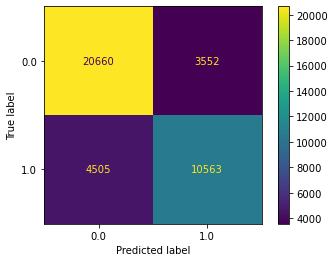

In [122]:
puntajes(X_test,X_train,y_test, y_test_pred, logreg)

In [123]:
logreg.score(X_test, y_test)

0.7948828920570264

### Conclusion

Vemos que la precision del modelo es un poco inferior pero semejante que la del modelo que uso solo 10 paises, por lo que podemos asumir que utilizar el dataset completo aporta un poco al entrenamiento del modelo haciendolo mas generalizado, pero no es realmente necesario. La seleccion que hicimos previamente fue lo suficientemente representativa.

## ¿Existe una relacion entre el promedio de dias que se hizo y no se hizo cuarentena, y el porcentaje de la poblacion contagiada acumulada?

In [124]:
excepciones = ["Africa","Asia","Europe","European Union","High income","Lower middle income","South America","Upper middle income","World"]

In [125]:
prom = data_cuarentena.groupby("Entity").mean().sort_values(by=["stay_home_requirements"])
prom

,stay_home_requirements
Entity,
Costa Rica,0.000000
Switzerland,0.000000
Ethiopia,0.000000
Cote d'Ivoire,0.000000
Tanzania,0.000000
...,...
Tonga,0.886935
Rwanda,0.891139
Jamaica,0.892720


In [126]:
por_poblacion = datos[["location","total_cases","population"]].groupby("location").max()

In [127]:
por_poblacion[por_poblacion.total_cases > 10000000]

,total_cases,population
location,,
Africa,11268386.0,1.373486e+09
Asia,120758420.0,4.678445e+09
Brazil,29040800.0,2.139934e+08
Europe,161250662.0,7.489630e+08
European Union,111173878.0,4.471899e+08
France,23064766.0,6.742200e+07
Germany,15830112.0,8.390047e+07
High income,240051555.0,1.214930e+09
India,42962953.0,1.393409e+09


In [128]:
por_poblacion.drop(labels=excepciones, inplace=True)

In [129]:
por_poblacion

,total_cases,population
location,,
Afghanistan,174331.0,39835428.0
Albania,272030.0,2872934.0
Algeria,265227.0,44616626.0
Andorra,38434.0,77354.0
Angola,98796.0,33933611.0
...,...,...
Vietnam,4232520.0,98168829.0
Wallis and Futuna,454.0,11094.0
Yemen,11775.0,30490639.0


In [130]:
por_poblacion["prom_cuarentena"] = prom.stay_home_requirements
por_poblacion["por_pob_contagiada"] = (por_poblacion.total_cases / por_poblacion.population) * 100

In [131]:
por_poblacion.dropna(inplace=True)
por_poblacion.isna().sum()

total_cases           0
population            0
prom_cuarentena       0
por_pob_contagiada    0
dtype: int64

In [132]:
por_poblacion

,total_cases,population,prom_cuarentena,por_pob_contagiada
location,,,,
Afghanistan,174331.0,39835428.0,0.217064,0.437628
Albania,272030.0,2872934.0,0.644025,9.468717
Algeria,265227.0,44616626.0,0.733758,0.594458
Andorra,38434.0,77354.0,0.016311,49.685860
Angola,98796.0,33933611.0,0.222083,0.291145
...,...,...,...,...
Venezuela,516578.0,28704947.0,0.730238,1.799613
Vietnam,4232520.0,98168829.0,0.603513,4.311470
Yemen,11775.0,30490639.0,0.465496,0.038618


In [133]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()

In [134]:
por_pob_reg = por_poblacion.por_pob_contagiada.values.reshape(-1,1)
prom_cuare_reg = por_poblacion.prom_cuarentena.values.reshape(-1,1)

linear_reg.fit(prom_cuare_reg,por_pob_reg)
y_pred = linear_reg.predict(prom_cuare_reg)

In [135]:
m = linear_reg.coef_[0][0]
c = linear_reg.intercept_[0]
print(m)
print(c)

-10.497767569794506
15.460856203530495


Text(0.5, 1.0, 'Relacion entre % de contagiados y promedio de dias hechos cuarentena')

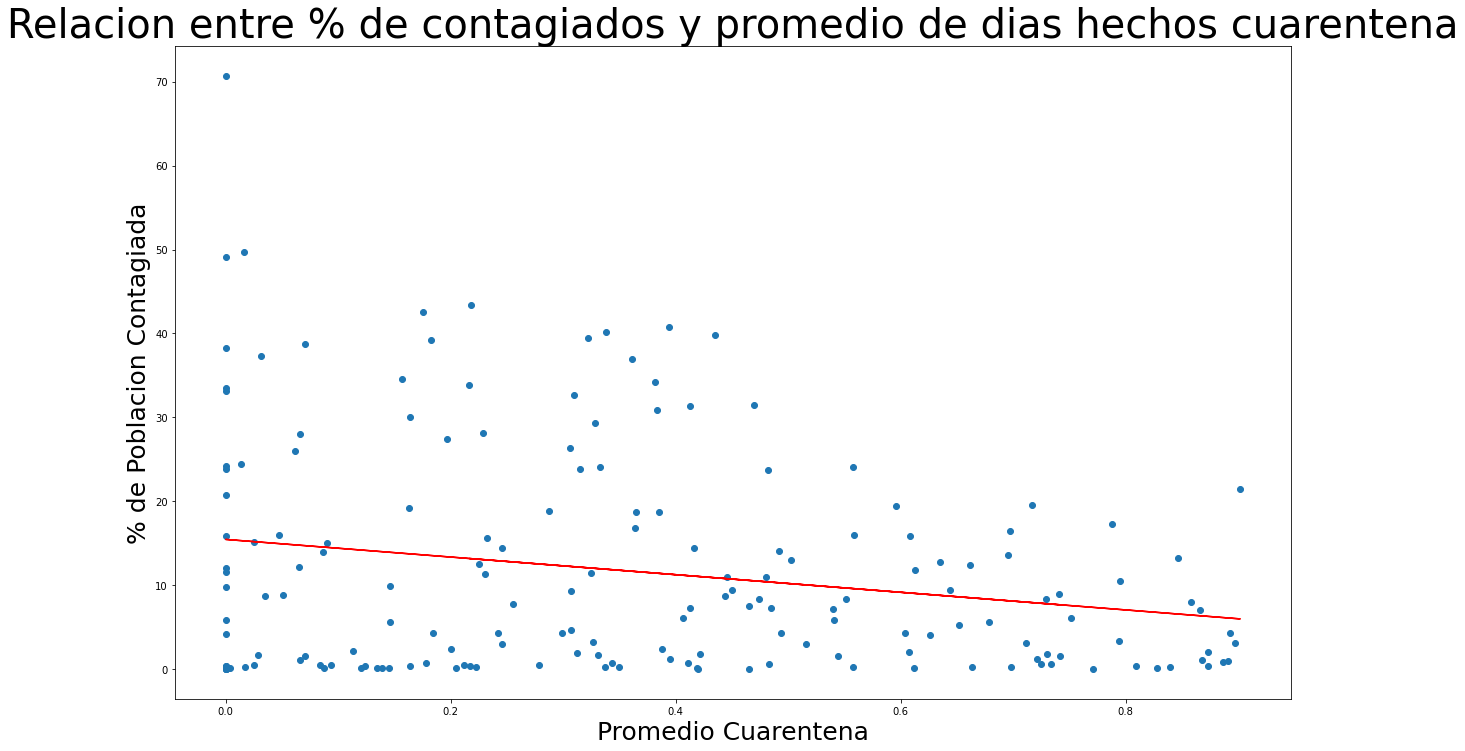

In [136]:
plt.figure(figsize=(20,12))
plt.scatter(por_poblacion.prom_cuarentena, por_poblacion.por_pob_contagiada)
plt.plot(prom_cuare_reg, y_pred, color="red")
plt.ylabel("% de Poblacion Contagiada", fontsize=25)
plt.xlabel("Promedio Cuarentena",fontsize=25)
plt.title("Relacion entre % de contagiados y promedio de dias hechos cuarentena", fontsize=40)


### Conclusion
 Vemos hay una leve tendencia que indica que al aumentar la cantidad de tiempo haciendo cuarentena, disminuye el porcentaje de poblacion contagiada. 

## ¿Como es la relacion entre el parametro de crecimiento "k" y el promedio del tiempo hecho cuarentena?

In [137]:
df_f.set_index("Pais", inplace=True)
df_f["prom"] = prom.stay_home_requirements
df_f.drop(columns=["t0","t"])

,k,prom
Pais,,
Germany,0.232304,0.287327
France,0.071268,0.381980
United Kingdom,0.105630,0.228717
Italy,0.152408,0.901887
Russia,0.082416,0.230866
Thailand,0.224437,0.184673
Brazil,0.084537,0.695107
Argentina,0.053590,0.716475
United States,0.189118,0.315121


In [138]:
linear_reg = LinearRegression()

In [139]:
X_k = df_f.k.values.reshape(-1,1)
y_k = df_f.prom.values.reshape(-1,1)

linear_reg.fit(X_k,y_k)
y_pred = linear_reg.predict(y_k)

(0.0033150499488142776, 0.4)

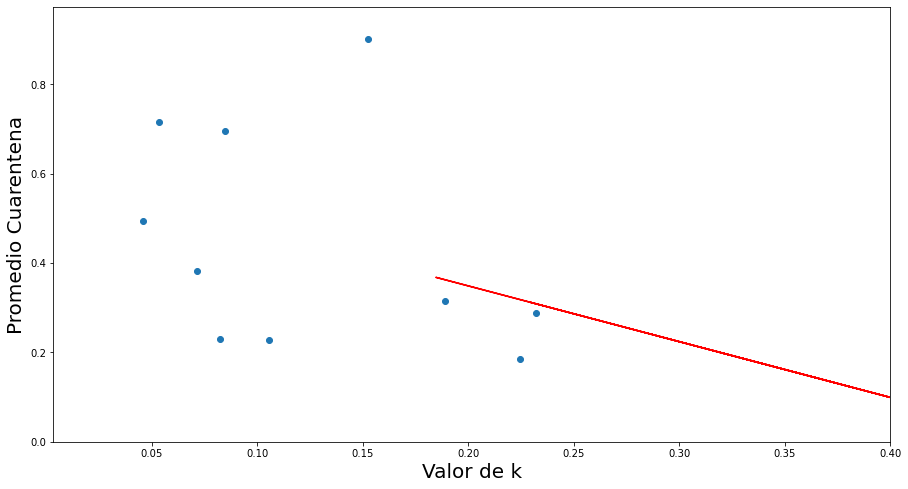

In [140]:
plt.figure(figsize=(15,8))
plt.scatter(df_f.k, df_f.prom)
plt.plot(y_k, y_pred, color="red")
plt.xlabel("Valor de k", fontsize=20)
plt.ylabel("Promedio Cuarentena", fontsize=20)
plt.ylim(bottom=0)
plt.xlim(right=0.4)

### Conclusion

Lo esperable es que al aumentar la cantidad de tiempo hecho cuarentena el valor de k sea menor, por lo que la tendencia acompaña la idea. Aun asi para poder saber si existe alguna tendencia real deberiamos calcular la ventana de tiempo de crecimiento exponencial de muchos mas paises, obtener su k y ver entonces si existe dicha tendencia.

# Informe

## Primera Parte - ¿Como empezo la pandemia?

En esta instancia se propuso analizar 10 paises con sus respectivas ventanas de tiempo donde los contagios de Covid-19 estaban en una fase de crecimiento exponencial. La cantidad de casos confirmados puede aproximarse  asi con la siguiente fórmula:
$C(t)=e^{k(t-t_0)}$

El valor de k esta relacionado con el tiempo en que una persona enferma contagia, el nivel de infecciosidad del virus, y por la circulacion de la gente. Una de las propuestas de este proyecto es ver efectivamente si este parametro k tiene relaciona con el tiempo hecho cuarentena de forma de que al hacer mas cuarentena, este valor disminuya. Esto se analizó en la parte de "investigacion" donde si bien obtuvimos la tendencia que esperamos, no es una conclusion estadisticamente robusta ya que solo utilizamos 10 paises.

![](images\k_vs_prom.jpeg)

El siguiente desafio fue realizar un intervalo de confianza para el promedio de k de los 10 paises seleccionados, y con este tratar de predecir el k mundial. Se propuso el siguiente flujo de trabajo para cada pais: 

![](images\wf_paises_parte1.png)


Al haber sido este intervalo de confianza muy grande y la metrica de error (RMSE) muy alta asumimos que el resultado de esto fue predeciblemente malo por varias razones: vimos que el valor de k esta sujeto a muchas variables dependientes de las condiciones politicas, poblacionales y culturales de los paises, no solo es que son pocos paises para poder hacer un modelo con una buena estimacion, sino que los paises deberian parecerse mucho entre si para que esto pueda suceder, y no es el caso. El k predicho fue de aproximadamente 0.12, cuando el real fue 0.099.

 ![](images\kpromedio.jpeg) ![](images\prediccion_k.jpeg) 


## Segunda Parte - Evaluando Estrategias

En esta parte del proyecto en primer lugar se busca escoger una medida sanitaria, en este caso fue la cuarentena, y 3 indicadores que esten relacionados con el impacto que tiene esta medida. Los indicadores seleccionados fueron:

**new_cases_smoothed_per_million** = Nuevos casos de COVID-19 (Media movil de 7 dias) por 1,000,000 habitantes. El contado incluye casos probables cuando son reportados.

**reproduction_rate** = Estimación en tiempo real del R (factor de reproduccion) efectivo del COVID-19

**stringency_index** = Indice de Rigurosidad de la Respuesta del Gobierno: es una medida compuesta basada en 9 indicadores que incluyen: cierres de escuelas, cierres de espacios de trabajo, prohibicion del transporte publico, etc. Esta reescalado a un valor entre 0 y 100, siendo 100 el valor de mas estricto.

Acerca de estos indicadores concluimos que no estaban correlacionados entre si, y cual fue la relevancia de cada uno para el modelo en funcion de su importancia. Esto lo vemos en los siguientes graficos:

![](images\corre_ind.jpeg) ![](images\ind_imp.jpeg)

El siguiente paso fue seleccionar 5 paises que no hayan hecho cuarentena y 5 que si para luego construir un clasificador binario a partir de una regresion logistica o Naive Bayes, que pueda predecir cuando un pais esta haciendo o no cuarentena. Previamente a realizar el modelo para los 10 paises a modo de ejemplo se probo el modelo para Argentina siendo estos los resultados:

**Modelo Argentina** 

![](images\arg_conf.jpeg) 

![](images\pred_arg.jpeg)

Vemos que el modelo funciona muy bien para predecir la cuarentena en este caso, no es una informacion concluyente pero nos da una idea de que el modelo podria funcionar bien.

**Modelo 10 Paises**

Los paises que hicieron cuarentena seleccionados fueron: Argentina, Mexico, China, India e Italia

Los paises que NO hicieron cuarentena seleccionados fueron: Suecia, Iran, Ukraine, Niger y Uruguay.

Los resultados para la Regresion Logistica en este caso fueron los siguientes:

![](images\conf_10p.jpeg)

Los resultados para Naive Bayes en este caso fueron los siguientes:

![](images\conf_10p_bayes.jpeg)

No hay un sobreajuste por parte de los modelos, la precision de ambos es relativamente buena, y vemos que la regresion logistica aparentemente es el clasificador que funciona mejor de los dos.

**Utilización del modelo para predecir paises nuevos**

Los paises utilizados para predecir en que momentos habian hecho cuarentena fueron España, Chile, Alemania, Estados Unidos, India, Francia, Rusia , Tailandia, Kazakhstan y Australia.

La precision del modelo de regresion logistica entrenado fue de ≈ 0.786 y la del modelo de Naive Bayes de ≈ 0,750. Con estos resultados podemos decir que el modelo de regresion logistica entrenado con 5 paises que hicieron cuarentena y 5 que no, puede hacer esta prediccion con una precision aceptable.

## Investigacion

**¿Como funciona el modelo si lo probamos con todos los paises del dataset?**

Con la intencion de llevar el modelo a una escala de mayor representatividad probamos entrenandolo con todos los paises del dataset. El resultado obtenido fue de una precision semejante a la que se obtuvo del modelo anterior de 10 paises, lo que nos da una idea de que ese modelo ya era lo suficientemente representativo.

![](images\conf_mundo.jpeg)

**¿Existe una relacion entre el promedio de dias que se hizo y no se hizo cuarentena, y el porcentaje de la poblacion contagiada acumulada?**

A forma de tener un indicio de la efectividad de realizar cuarentena en funcion de disminuir la cantidad de contagios, vemos cual es la relacion entre el % de contagiados (expresado como casos totales / poblacion) y el promedio de la cantidad dias en que ese pais hizo cuarentena. Lo esperable es ver que a mayor cantidad de dias hechos cuarentena (mayor valor de Promedio Cuarentena) el % de Poblacion Contagiada sea menor, y justamente esto es lo que vemos en el gráfico.

![](images\porcen_vs_prom.jpeg)

